In [183]:
import os
import medusa
from pickle import load
import pandas as pd

import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [89]:
# load the gene and reaction knockout dataframes
gene_knockout_results = {}
reaction_knockout_results = {}
for fname in os.listdir('../results/reaction_knockouts/'):
    species = fname.split('.')[0]
    reaction_knockout_results[species] = pd.read_csv(
        '../results/reaction_knockouts/'+species+'.csv',sep=',',index_col=0)
    
for fname in os.listdir('../results/gene_knockouts/'):
    species = fname.split('.')[0]
    gene_knockout_results[species] = pd.read_csv(
        '../results/gene_knockouts/'+species+'.csv',sep=',',index_col=0)

In [153]:
# load the ensembles, which we will need later.
# load all ensembles
ensembles = {}
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia']
for species_file in os.listdir("../results/ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/ensembles/"+species_name+".pickle",'rb') as infile:
            ensembles[species_name] = load(infile)

In [154]:
feature_frames = {}
for species in ensembles.keys():
    ensemble = ensembles[species]
        
    # Grab the features and states for the ensemble and convert to a dataframe
    feature_dict = {}
    for feature in ensemble.features:
        feature_dict[feature.id] = feature.states
    feature_frame = pd.DataFrame.from_dict(feature_dict)

    # Convert to a boolean dataframe for faster computation
    # (0 values become False, all others become True (i.e. active features))
    feature_frames[species] = feature_frame.astype(bool)

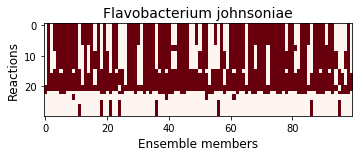

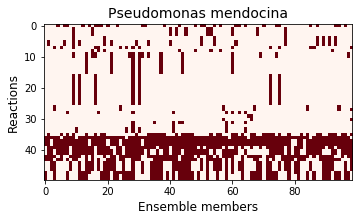

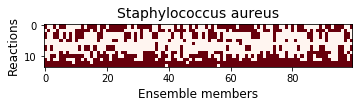

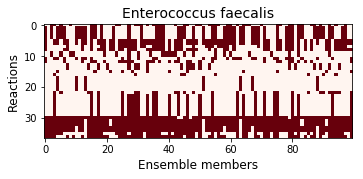

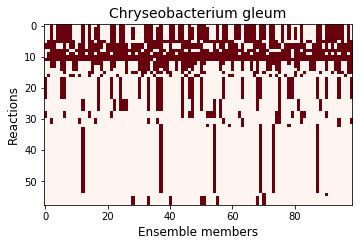

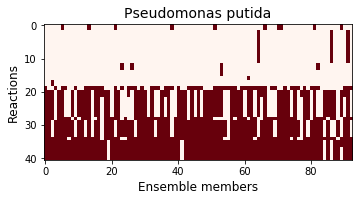

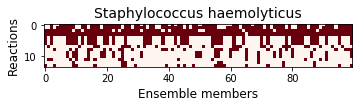

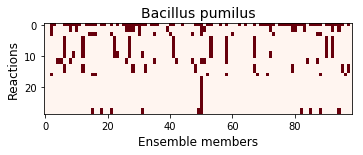

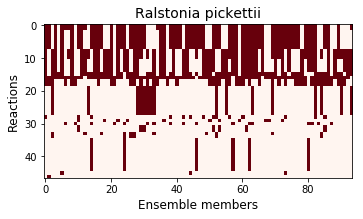

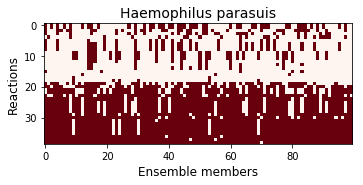

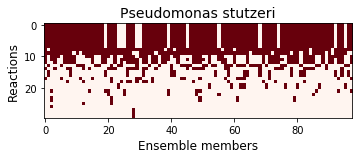

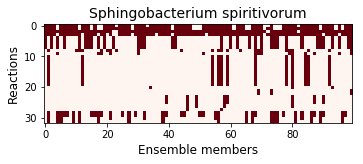

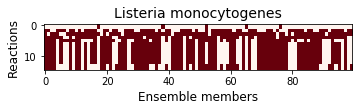

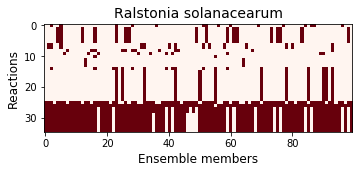

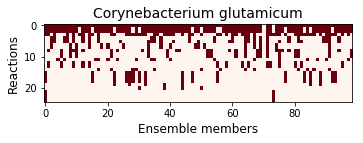

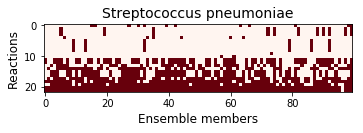

In [138]:
for species in reaction_knockout_results.keys():
    # for this species, create a dataframe that has reactions that never had an effect
    # on growth removed for visualization
    plotframe = reaction_knockout_results[species]
    
#     # normalize each ensemble's knockout results by dividing by it's max growth rate
#     plotframe = plotframe.div(plotframe.max(axis=0), axis=1)
    
#     plotframe = plotframe.loc[(plotframe > 1E-8).sum(axis=1) < len(plotframe.columns)]
#     # Also remove reactions that were essential in all members
#     plotframe = plotframe.loc[(plotframe < 1E-8).sum(axis=1) != len(plotframe.columns)]

    plotframe = plotframe > 1E-6
    plotframe = plotframe.loc[(plotframe == 0).sum(axis=1) != len(plotframe.columns)]
    plotframe = plotframe.loc[(plotframe == 1).sum(axis=1) < len(plotframe.columns)]
    plotvals = plotframe.values

    # reorder by heirarchical clustering of reactions
    dgram = dendrogram(linkage(pdist(plotvals,metric='euclidean')),labels=plotframe.index,no_plot=True)
    plotframe = plotframe.reindex(dgram['ivl'])
    plotvals = plotframe.values

    #plotvals = plotvals/plotvals.max()
    rxn_labels = plotframe.index

    fig, ax = plt.subplots()
    im = ax.imshow(plotvals,cmap='Reds')
    ax.set_xlabel('Ensemble members',size=12)
    ax.set_ylabel('Reactions',size=12)
    ax.set_title(species,size=14)
    fig.tight_layout()
    fig.set_size_inches(5,5)
    fig.savefig('../results/reaction_knockout_plots/'+species+'_rxn_knockouts.png')
    fig.savefig('../results/reaction_knockout_plots/'+species+'_rxn_knockouts.svg')

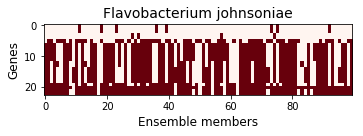

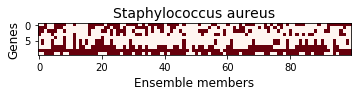

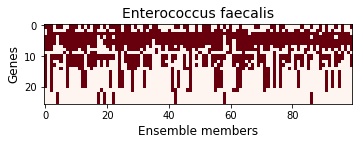

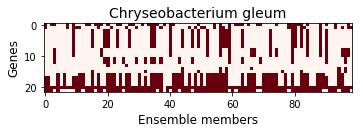

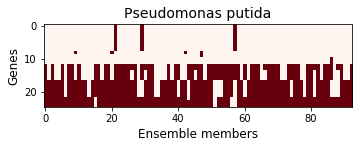

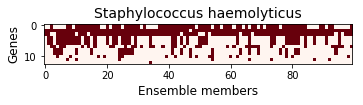

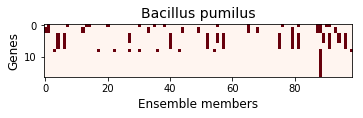

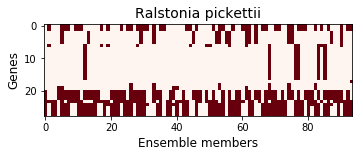

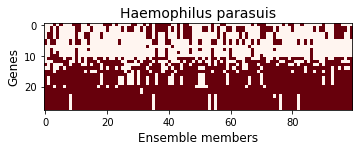

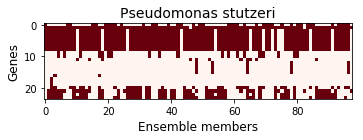

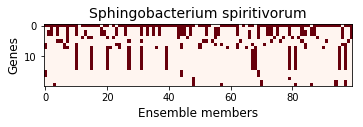

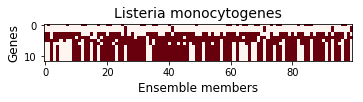

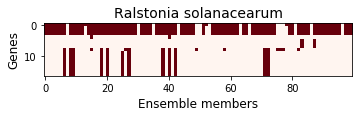

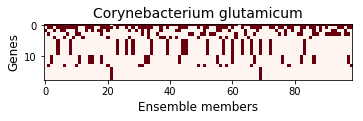

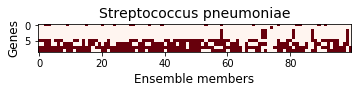

In [137]:
for species in gene_knockout_results.keys():
    # for this species, create a dataframe that has genes that never had an effect
    # on growth removed for visualization
    plotframe = gene_knockout_results[species]
    
    
    # normalize each ensemble's knockout results by dividing by it's max growth rate
    #plotframe = plotframe.div(plotframe.max(axis=0), axis=1)
    
    # binarize the data
    
    #plotframe = plotframe.loc[(plotframe > 1E-8).sum(axis=1) < len(plotframe.columns)]
    # Also remove reactions that were essential in all members
    #plotframe = plotframe.loc[(plotframe < 1E-8).sum(axis=1) != len(plotframe.columns)]
    
    plotframe = plotframe > 1E-6
    plotframe = plotframe.loc[(plotframe == 0).sum(axis=1) != len(plotframe.columns)]
    plotframe = plotframe.loc[(plotframe == 1).sum(axis=1) < len(plotframe.columns)]
    plotvals = plotframe.values
    
    # reorder by heirarchical clustering of reactions
    dgram = dendrogram(linkage(pdist(plotvals,metric='hamming')),labels=plotframe.index,no_plot=True)
    plotframe = plotframe.reindex(dgram['ivl'])
    plotvals = plotframe.values

    #plotvals = plotvals/plotvals.max()
    rxn_labels = plotframe.index

    fig, ax = plt.subplots()
    im = ax.imshow(plotvals,cmap='Reds')
    ax.set_xlabel('Ensemble members',size=12)
    ax.set_ylabel('Genes',size=12)
    ax.set_title(species,size=14)
    fig.tight_layout()
    fig.set_size_inches(5,5)
    fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.png')
    fig.savefig('../results/gene_knockout_plots/'+species+'_gene_knockouts.svg')

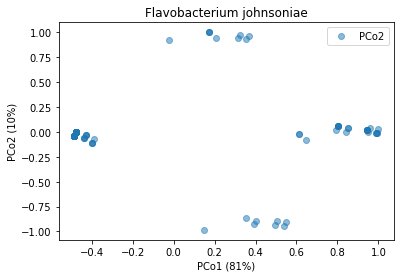

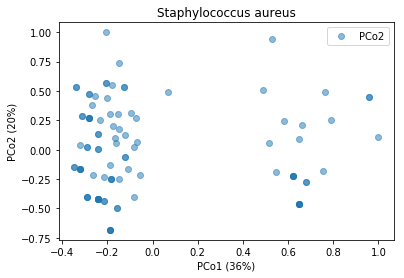

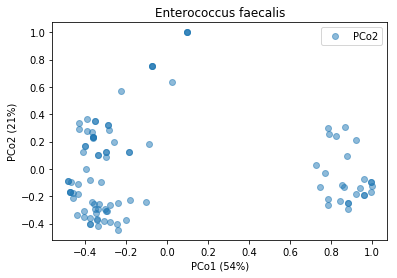

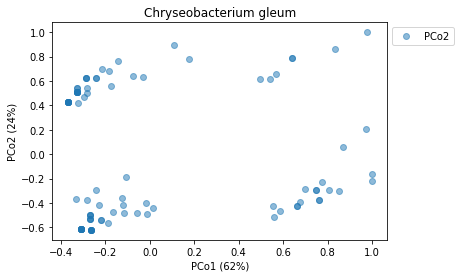

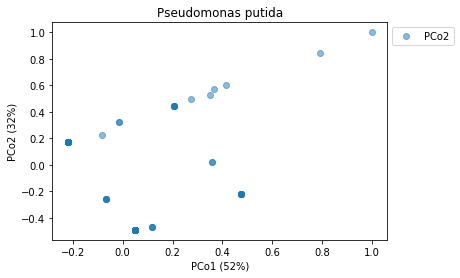

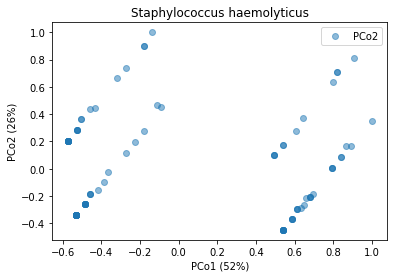

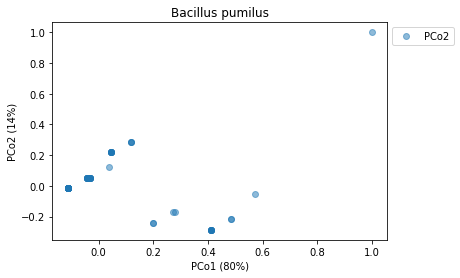

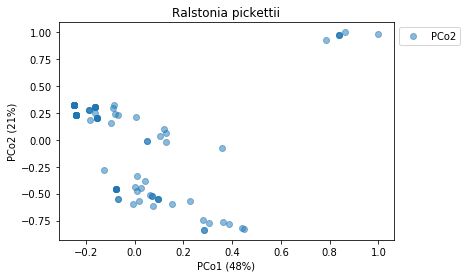

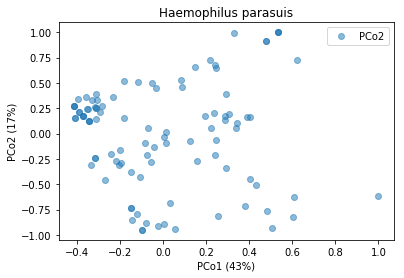

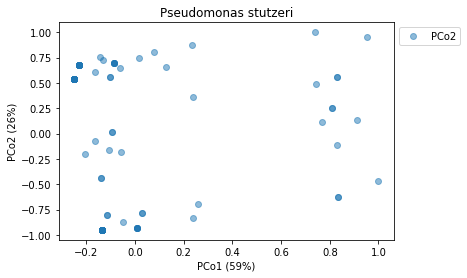

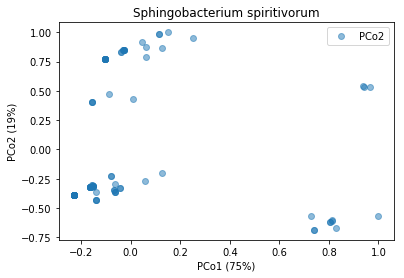

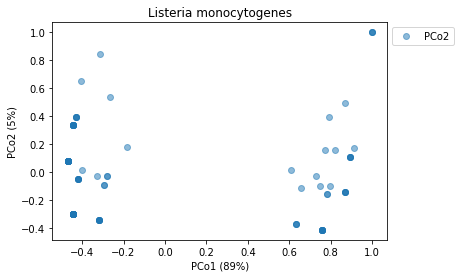

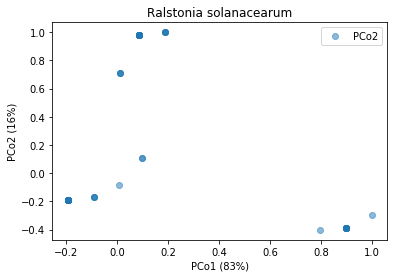

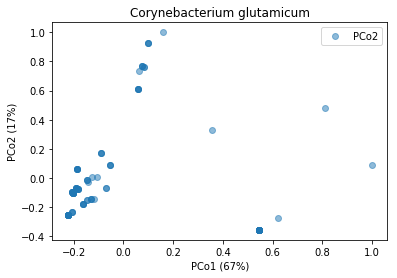

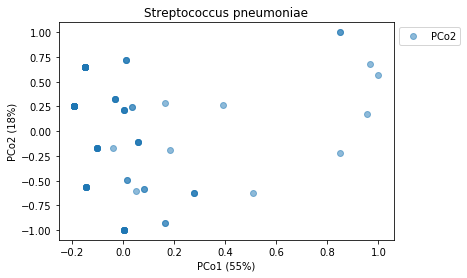

In [197]:
# Calculate the gene knockout distance between ensemble members, perform PCA on the distance
# matrix, then regress on PC1.
pipe_w_scale = make_pipeline(StandardScaler(), PCA(n_components=2))
regress_pipe = make_pipeline(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1))
classifiers = {}
for species in gene_knockout_results.keys():
    if species not in ["Stenotrophomonas maltophilia"]:
        df_for_pca = gene_knockout_results[species]
        
        df_for_pca = df_for_pca > 1E-6
        df_for_pca = df_for_pca.loc[(df_for_pca == 0).sum(axis=1) != len(df_for_pca.columns)]
        df_for_pca = df_for_pca.loc[(df_for_pca == 1).sum(axis=1) < len(df_for_pca.columns)]
        df_for_pca = df_for_pca.T

        pca_input = 1 - squareform(pdist(df_for_pca,metric="hamming"))
        pipe_w_scale.fit(pca_input)

        pc1 = pipe_w_scale.transform(pca_input)[:,0]
        pc2 = pipe_w_scale.transform(pca_input)[:,1]

        # Add scores for each sample back to the dataframes
        df_for_pca['PCo1'] = pc1/max(abs(pc1))
        df_for_pca['PCo2'] = pc2/max(abs(pc2))
        
        # grab the ensembles feature frame, fit the RF regressor
        feature_frame = feature_frames[species]
        input_cols = feature_frame.columns
        df_for_pca = df_for_pca.reset_index().merge(feature_frame,on=df_for_pca.index).drop("key_0",axis=1)
        df_for_pca.index = df_for_pca["index"]
        df_for_pca = df_for_pca.drop("index",axis=1)
        # perform 5-fold cross-validated regression using boosted trees
        classifiers[species] = RandomForestRegressor(
            n_estimators=100, oob_score=True).fit(
            df_for_pca[input_cols],df_for_pca['PCo1'])
        

        # get variance explained for PC1/PC2
        pc1_var = pipe_w_scale.named_steps.pca.explained_variance_[0]
        pc2_var = pipe_w_scale.named_steps.pca.explained_variance_[1]

        fig, ax = plt.subplots()
        ax.plot(df_for_pca['PCo1'],df_for_pca['PCo2'],marker='o',linestyle='', alpha = 0.5)
        ax.set_title(species)
        ax.set_xlabel('PCo1 (%d%%)' % pc1_var)
        ax.set_ylabel('PCo2 (%d%%)' % pc2_var)

        plt.legend(bbox_to_anchor=(1,1))

In [201]:
species = "Staphylococcus aureus"
clf = classifiers[species]
pd.DataFrame(clf.feature_importances_,index=feature_frames[species].columns).sort_values(by=0,ascending=False)

,0
rxn01360_c_upper_bound,0.036994
rxn05554_c_upper_bound,0.026289
rxn05563_c_lower_bound,0.026242
rxn00705_c_upper_bound,0.022370
rxn05554_c_lower_bound,0.020871
rxn05563_c_upper_bound,0.020608
rxn00705_c_lower_bound,0.020230
rxn00916_c_lower_bound,0.017639
rxn09180_c_lower_bound,0.016214
rxn05604_c_upper_bound,0.013831


-1.1726258106198826e-09

In [124]:
(gene_knockout_results['Staphylococcus aureus'].div(
    gene_knockout_results['Staphylococcus aureus'].max(axis=0),axis=1).loc['93061.5.peg.1069']).mean()

0.03916127231024114

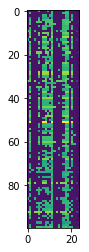

In [46]:
fig,ax=plt.subplots()
ax.imshow(df_for_pca.values)